# Quantifying Reconstruction Error
## Replicate tracings of a lamina cartridge

The reconstruction of each lamina circuit can broken down into three distinct steps

1. An annotator performs an initial dense reconstruction of an assigned cartridge: Every neurite contained within the cartridge is  labelling every synaptic connection indentified. A critical step of the initial reconstruction is the identification of a siginificant majority (~90%) of the cartridge's postsynaptic arbors by tracing 'backwards' from each unidentified neurite until the arbor connects to a known neuron. 
2. A different annotator will then perform a peer-review of the initial reconstruction. Each synaptic terminal associated with the cartridge is visited to ensure that post synaptic partners were labelled according to our criteria. 
3. Lastly, a senior member of the team will review the number of connection between all the neurons in the cartridge, along with the neuron's branch structure to determine if any outlying features are legittimate anomalies or the result of a skeletal tracing error. 

To quantify the observed variability in our connectome that could be explained by our reconstruction methodology, our four annotators performed replicate tracings of a previously untraced lamina cartridge. These replicates were produced independently before being subject to our review process outlined above. 

We observed that the variability of contact contact counts among different cartridges in our lamina connectome exceeds the variability we observe in our replicate experiment, where the same structure was reconstructed by different people. A significant source of variability between our replicates was the result of errors in skeletal representation, for example, a missing branch or a misattributed arbor. Depending on the length of skeleton missed or misattributed, these errors can cause significant outliers in the number of contacts observed for a particular type of connection. These errors were present both in our connectome and in our replicate experiment. Our analysis suggests that skeletal errors causing significant descripencies in contact counts are sufficiently mitigated by our review process. By reconstructing a series of stereotyped circuits, we can continuosly refer to our model to pinpoint potential skeletal errors, a task that is typically very difficult and inefficient to do naively (like finding a needle in a haystack). Once a discrepency is identified in either the individual circuit's adjacency matrix or dendrogram, we determine if the discrepency is an actual biological anomaly (which we have examples of) or the result of a mistake. Before performing a correction, we require both the identification of a point of failure (a location on the skeleton that crosses a membrane boundary into another cell) along with an alternative path that links the disconnected arbor to a known neurite without crossing any cell membranes. If we are certain a membrane was cross, but are unable to link the arbor to a known neurite, the arbor will be given an unidentified status, and factored into the cartridge's fraction of unidentified synaptic contacts.  

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
from sklearn.linear_model import LinearRegression
from scipy.stats import mannwhitneyu

from src.fig_utils import hex_to_rgb

from IPython.display import display, Math, Latex

In [33]:
plt.rcParams['lines.linewidth'] = 2
mpl.rc('font', size=14)
plt.style.use('default')

In [34]:
# Lamina connectome - synaptic contacts (use most recent fetch)
tp = '200507'
lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')

# Replicate connectome - synaptic contacts
# Review timepoints: 200121, 200117, 200113, 200108, 191219
val_tp = "200121"
val_data_path = f"~/Data/{val_tp}_exp2/{val_tp}_linkdf.pickle"
val_links = pd.read_pickle(val_data_path)

In [35]:
#val_links

In [51]:
# Semantic details
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])
annotators = np.unique(val_links["pre_om"])
ommatidia = np.unique(lamina_links['pre_om'])
# all possible ('pre', 'post') permutations
all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
# Colors to distinguish data from the connectome (grey) and data from the validation experiment (red)
cm = {'val': "#383a3f", 
     'lam': "#bf3b46"}

### Preprocess connectivity data
- Transform to a wide dataframe with each connection type as a column 
- LMC_4 ctypes in ommatidia without L4 neurons are counted as np.nan
- ignores interommatidial connections TODO: include

In [52]:
# cx counts from lamina connectome
df_lamina_all = pd.DataFrame(index=ommatidia, columns=all_ctype_labels)
for om, row in df_lamina_all.iterrows():
    for c in all_ctype_labels:
        pre_t, post_t = c.split('->')
        # Cartridges on the posterior edge lack L4, so their counts for these connections are NaNed 
        if om in ['B0', 'E4', 'E5', 'E6', 'E7', 'D2'] and (post_t == 'LMC_4'):
            df_lamina_all.loc[om, c] = np.nan
        else:
            df_lamina_all.loc[om, c] = sum((lamina_links.pre_om == om) & (lamina_links.post_om == om) & 
                                           (lamina_links.pre_type == pre_t) & (lamina_links.post_type == post_t))

# cx counts from validation experiment
df_val_all = pd.DataFrame(index=annotators, columns=all_ctype_labels)
for annot, row in df_val_all.iterrows():
    for c in all_ctype_labels:
        pre_t, post_t = c.split('->')
        df_val_all.loc[annot, c] = sum((val_links.pre_om == annot) & (val_links.post_om == annot) & 
                                       (val_links.pre_type == pre_t) & (val_links.post_type == post_t))

### Define connection types to compare
Options: 
1. 'mean_thresh': Threshold by mean connection counts from the lamina connectome
2. 'consistently_observed': Exclude connections not observed in every lamina cartridge
3. 'all': All (n_subtypes x n_subtypes) possible synaptic permutations

In [53]:
inclusion = 'mean_tresh'

sig_thresh = 1.0  # not used for 'all'

######### 2. mean count must exceed threshold  
if inclusion == 'mean_tresh':
    sig_cx = (df_lamina_all.mean() >= sig_thresh).index
    display(sig_cx)
    df_lamina = df_lamina_all.loc[:, sig_cx]
    df_val = df_val_all.loc[:, sig_cx]
    incl_method = f"Connections with mean contact count >= {sig_thresh} across all lamina cartridges"
######### 3. is ctype > thresh in every circuit
elif inclusion == 'consistently_observed':
    criteria = [(df_lamina_all[ct].dropna() >= sig_thresh).all() for ct in df_lamina_all.columns]
    df_lamina = df_lamina_all.loc[:, criteria]
    df_val = df_val_all.loc[:, criteria]
    incl_method = f"Connections observed with contact count >= {sig_thresh} in all lamina cartridges"
######### 3. All connections (DEFAULT)
else:
    if inclusion != 'all':
        print("For inclusion criteria, pick either 'all', 'mean_thresh', or 'consistently_observed'. Defaulting to 'all'")
    df_lamina = df_lamina_all
    df_val = df_val_all
    incl_method = "All connection types"

sig_cts = df_val.columns
assert(len(df_val.columns) == len(df_lamina.columns)) 
print(f"\n{len(sig_cts)} significant connection types (out of a total possible {len(all_ctypes)} pre/post permutations)")

Index(['LMC_1->LMC_1', 'LMC_1->LMC_2', 'LMC_1->LMC_3', 'LMC_1->LMC_4',
       'LMC_1->LMC_N', 'LMC_1->R1R4', 'LMC_1->R2R5', 'LMC_1->R3R6',
       'LMC_1->R7', 'LMC_1->R7p',
       ...
       'centri->LMC_4', 'centri->LMC_N', 'centri->R1R4', 'centri->R2R5',
       'centri->R3R6', 'centri->R7', 'centri->R7p', 'centri->R8',
       'centri->UNKNOWN', 'centri->centri'],
      dtype='object', length=169)


169 significant connection types (out of a total possible 169 pre/post permutations)


### Comparing the variance of different connection types

In [54]:
'''
n_ex = 12  # show n ctypes with the largest and smallest variance in our connectome
low_cts = lamina_var.head(n_ex).index
high_cts = lamina_var.tail(n_ex).index

fig, axes = plt.subplots(n_ex, 2, figsize=(20, 6*n_ex), sharey=True)
for i in range(0, n_ex):
    # low var ctypes
    bp = axes[i, 0].boxplot(x=[df_lamina[low_cts[i]], df_val[low_cts[i]]],
                            labels=['Lamina connectome', 'Validation experiment'], 
                            patch_artist=True, vert=True)
    
    bp["boxes"][0].set_facecolor(cm['lam'])
    bp["boxes"][1].set_facecolor(cm['val'])
    axes[i, 0].set_title(low_cts[i])
    # high var ctypes
    bp = axes[i, 1].boxplot(x=[df_lamina[high_cts[i]], df_val[high_cts[i]]],
                            labels=['Lamina connectome', 'Validation experiment'], 
                            patch_artist=True, vert=True)
    
    bp["boxes"][0].set_facecolor(cm['lam'])
    bp["boxes"][1].set_facecolor(cm['val'])
    axes[i, 1].set_title(high_cts[i])
'''

'\nn_ex = 12  # show n ctypes with the largest and smallest variance in our connectome\nlow_cts = lamina_var.head(n_ex).index\nhigh_cts = lamina_var.tail(n_ex).index\n\nfig, axes = plt.subplots(n_ex, 2, figsize=(20, 6*n_ex), sharey=True)\nfor i in range(0, n_ex):\n    # low var ctypes\n    bp = axes[i, 0].boxplot(x=[df_lamina[low_cts[i]], df_val[low_cts[i]]],\n                            labels=[\'Lamina connectome\', \'Validation experiment\'], \n                            patch_artist=True, vert=True)\n    \n    bp["boxes"][0].set_facecolor(cm[\'lam\'])\n    bp["boxes"][1].set_facecolor(cm[\'val\'])\n    axes[i, 0].set_title(low_cts[i])\n    # high var ctypes\n    bp = axes[i, 1].boxplot(x=[df_lamina[high_cts[i]], df_val[high_cts[i]]],\n                            labels=[\'Lamina connectome\', \'Validation experiment\'], \n                            patch_artist=True, vert=True)\n    \n    bp["boxes"][0].set_facecolor(cm[\'lam\'])\n    bp["boxes"][1].set_facecolor(cm[\'val\'])\n  

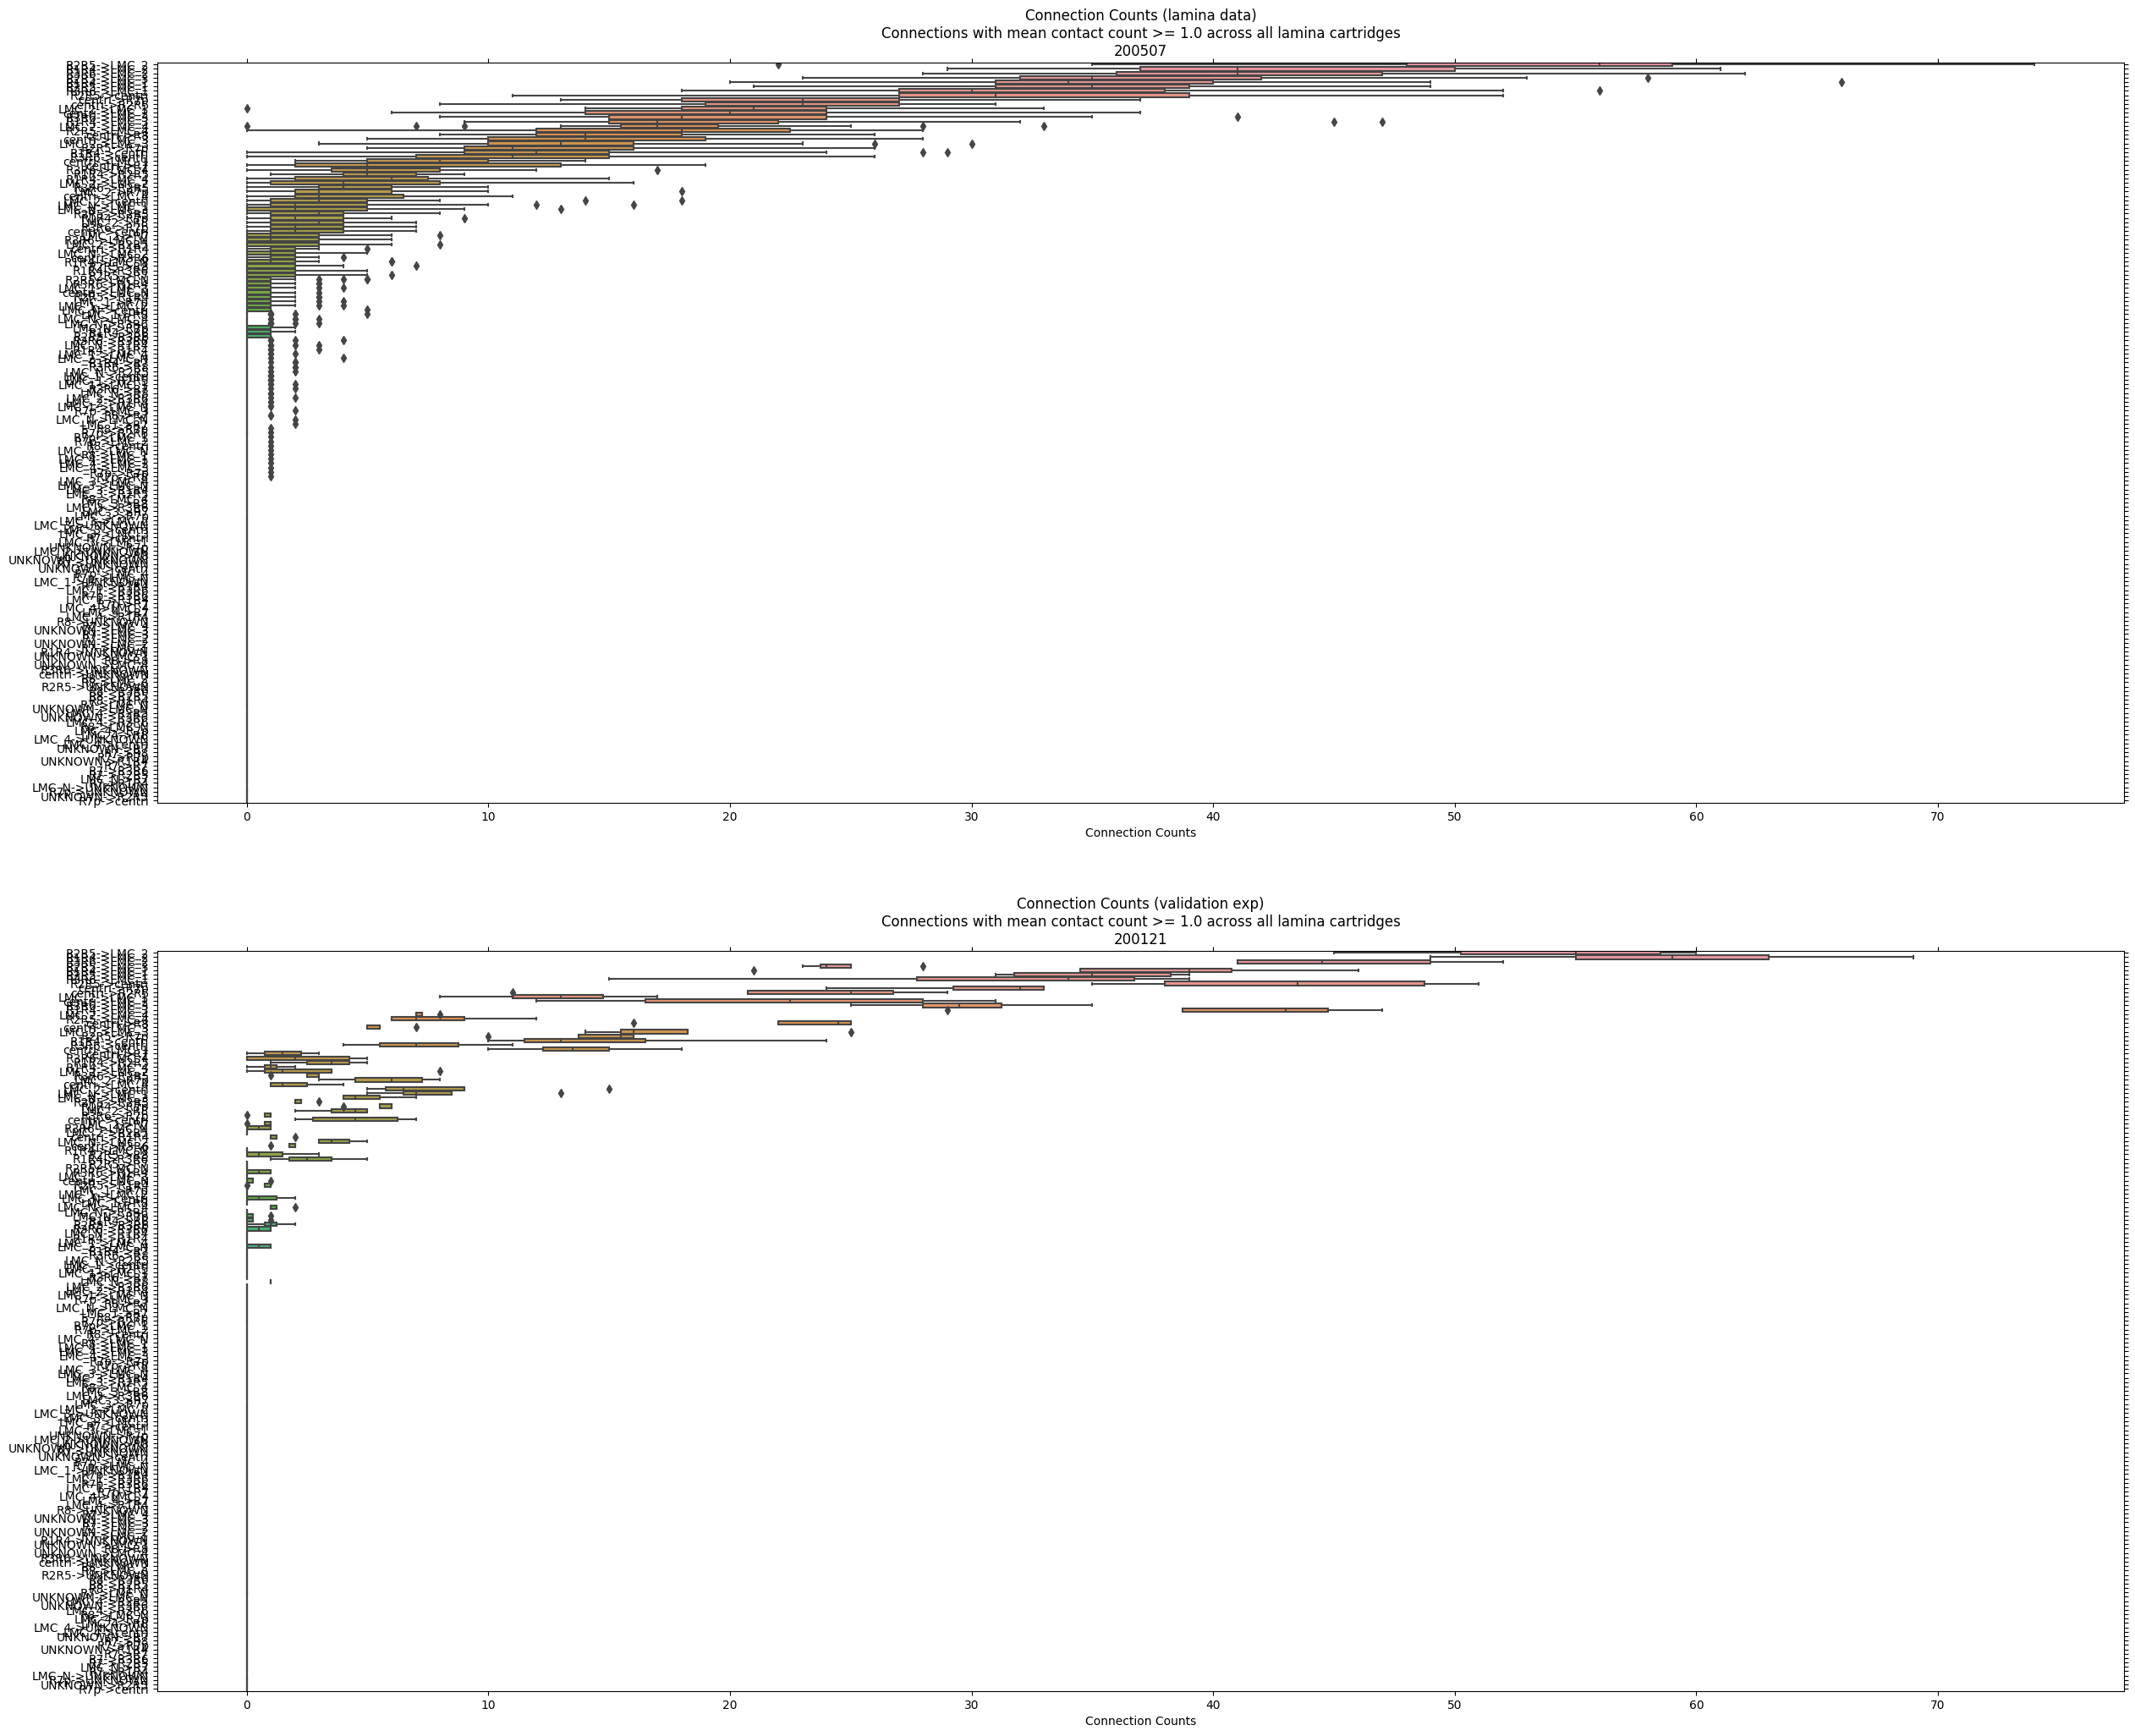

In [55]:
ctype_order = df_lamina.mean().sort_values(ascending=False).index

fig, ax = plt.subplots(2,1 , figsize=[30, 25], sharex=True)
sns.boxplot(data = df_lamina[ctype_order].to_numpy(), ax=ax[0], orient='h')
sns.boxplot(data = df_val[ctype_order].to_numpy(), ax=ax[1], orient='h')

ax[0].set_title("Connection Counts (lamina data)\n" + incl_method + '\n' + tp)
ax[1].set_title("Connection Counts (validation exp)\n" + incl_method + '\n' + val_tp)

ax[0].set_yticklabels(ctype_order.to_numpy())
ax[1].set_yticklabels(ctype_order.to_numpy())


ax[0].set_xlabel('Connection Counts')
ax[1].set_xlabel('Connection Counts')

ax[0].tick_params(reset=True)
ax[1].tick_params(reset=True)




In [56]:
def fano(df):
    return (df.std() ** 2)/df.mean()

'''
def fano(df):
    return (df.std() ** 2)/df.mean()

def coef_var(df):
    return df.std()/df.mean()
'''

'\ndef fano(df):\n    return (df.std() ** 2)/df.mean()\n\ndef coef_var(df):\n    return df.std()/df.mean()\n'

### Fano factor: a measure of dispersion for a set of observations
- For a given connection type (e.g. LMC_2 -> LMC_1), we have a set of observed connection counts dispersed around a mean value
- Because mean counts can differ significantly between types, we use Fano factor to describe a unitary deviation, scaled by the mean, that can be compared across connection types or aggregated to obtain an overall measure of dispersion in our data

$$D = \frac{\sigma^2}{\mu}$$

NOTE: Mean is not robust to outliers. Counts that are typically close to 0, but much higher because of a mistake in a particular observation, will have a very large fano factor. Ask mitya about using median for such a small n in our validation exp

Outliers are examined during a step of peer-review. When a connection count is much larger than the average or if a previously unobserved connection type is present, it is almost always due to a mistake in the skeletal reconstruction. 

95

57

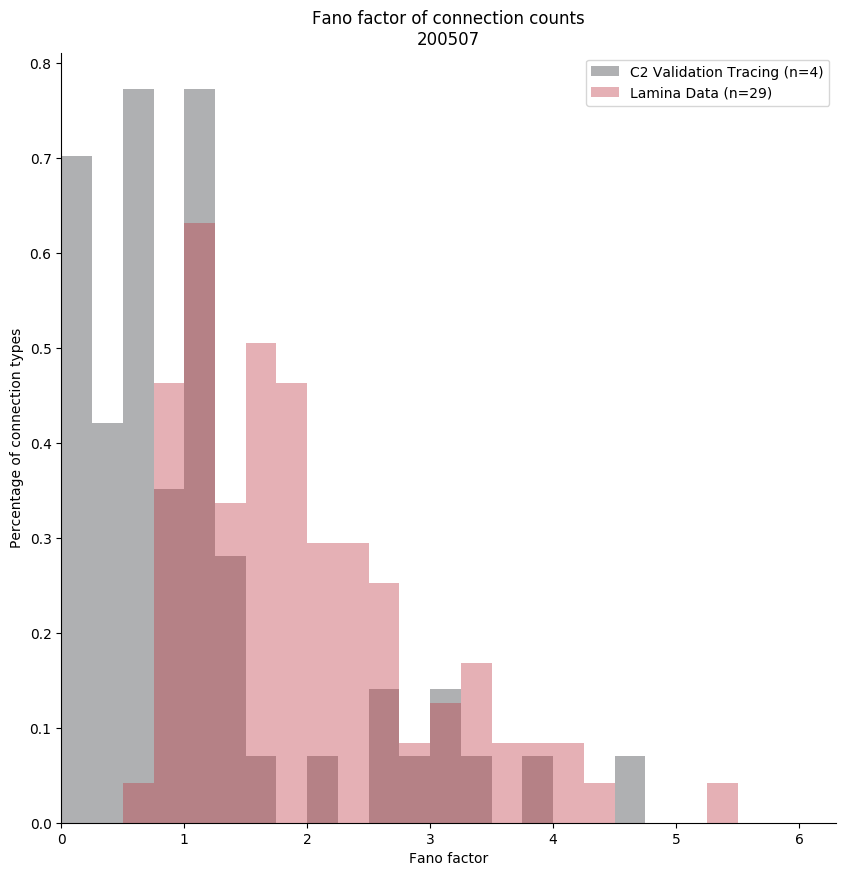

In [65]:
fig, ax = plt.subplots(1, figsize=[10, 10])
lamina_fano = fano(df_lamina).dropna().T
val_fano = fano(df_val).dropna().T

display(len(lamina_fano))
display(len(val_fano))

max_fano = max([lamina_fano.max(), val_fano.max()])
interval = np.arange(0, max_fano + (10 - max_fano % 10), 0.25)  # round up to nearest 10

sns.distplot(val_fano, bins = interval, kde=False, norm_hist=True,
             ax=ax, color=cm['val'], label='C2 Validation Tracing (n=4)')
sns.distplot(lamina_fano, bins = interval, kde=False, norm_hist=True,
             ax=ax, color=cm['lam'], label=f'Lamina Data (n={len(ommatidia)})')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(f"Fano factor of connection counts\n")
ax.set_xlabel("Fano factor")
ax.set_ylabel("Percentage of connection types")
ax.set_xlim([0, max_fano + 1])
ax.legend()

fig.savefig('/mnt/home/nchua/Dropbox/200615_valfano_95v57.pdf')

In [68]:
s, p = mannwhitneyu(val_fano, lamina_fano, alternative='less')
print("###### RESULTS ######")
print(f"Test statistic: {s}, p-value: {p: .10f}")
if p > 0.001:
    print("Fail to reject null")
else:
    print("Reject null: fano factor of validation connection counts is smaller")

###### RESULTS ######
Test statistic: 1100.0, p-value:  0.0000000005
Reject null: fano factor of validation connection counts is smaller


95

57

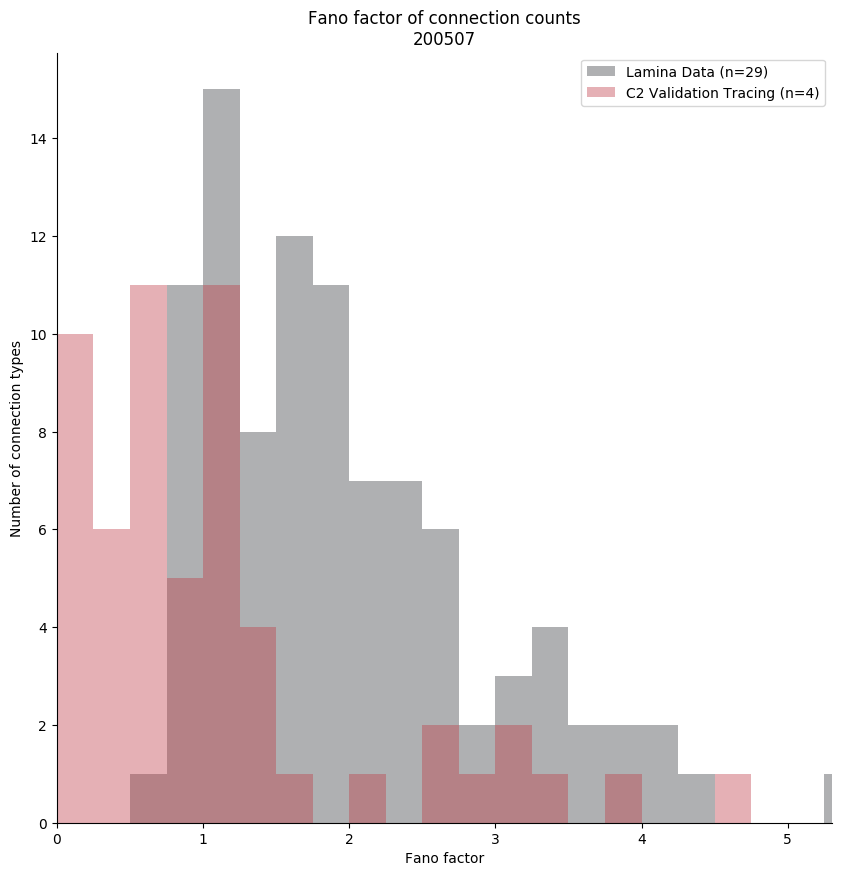

In [44]:
fig, ax = plt.subplots(1, figsize=[10, 10])
lamina_fano = fano(df_lamina).dropna().T
val_fano = fano(df_val).dropna().T

#lamina_fano = lamina_fano[val_fano.index]

display(len(lamina_fano))
display(len(val_fano))

max_fano = max([lamina_fano.max(), val_fano.max()])
interval = np.arange(0, max_fano + (10 - max_fano % 10), 0.25)  # round up to nearest 10

sns.distplot(lamina_fano, bins = interval, kde=False,
             ax=ax, color=cm['lam'], label=f'Lamina Data (n={len(ommatidia)})')
sns.distplot(val_fano, bins = interval, kde=False,
             ax=ax, color=cm['val'], label='C2 Validation Tracing (n=4)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title(f"Fano factor of connection counts\n{tp}")
ax.set_xlabel("Fano factor")
ax.set_ylabel("Number of connection types")
ax.set_xlim([0, max_fano])
ax.legend()

fig.savefig('/mnt/home/nchua/Dropbox/200614_valfano_57v95_counts.pdf')

(0, 114.99999999999999)

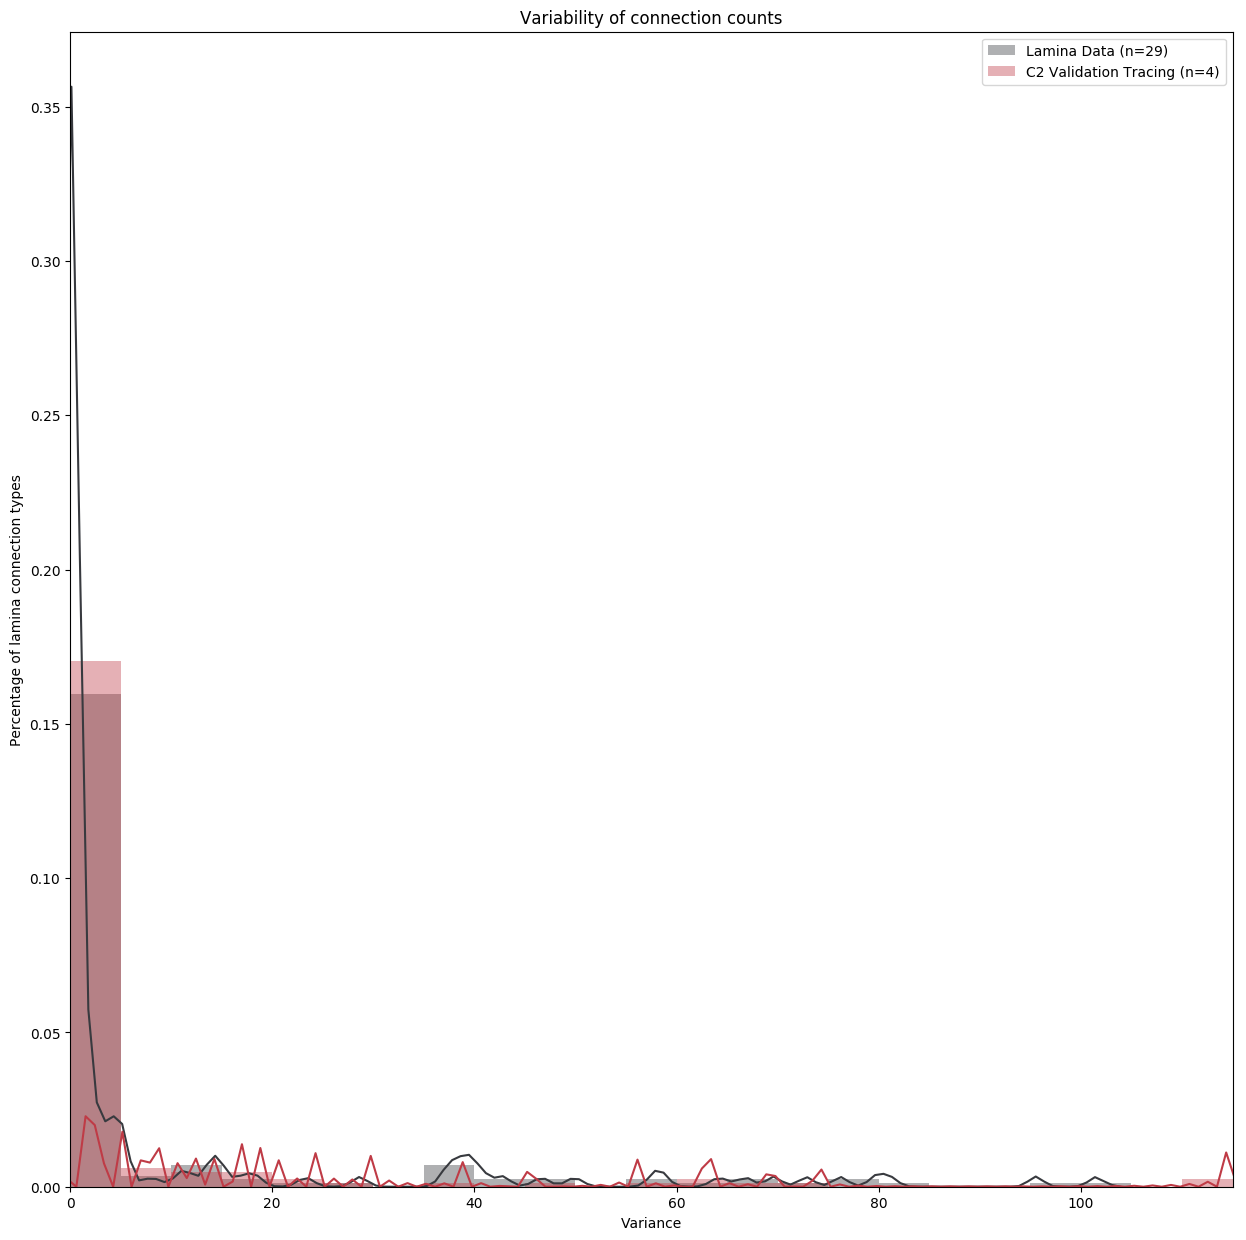

In [45]:
lamina_var = df_lamina.std().dropna().T ** 2
val_var = df_val.std().T ** 2

max_var = max([lamina_var.max(), val_var.max()])
interval = np.arange(0, max_var + (50 - max_var % 50), 5)

fig, ax = plt.subplots(1, figsize=[15, 15])

sns.distplot(lamina_var, bins=interval,
             ax=ax, color=cm['lam'], label=f'Lamina Data (n={len(ommatidia)})')
sns.distplot(val_var, bins=interval, 
             ax=ax, color=cm['val'], label='C2 Validation Tracing (n=4)')

ax.set_title("Variability of connection counts")
ax.set_xlabel("Variance")
ax.set_ylabel("Percentage of lamina connection types")
ax.legend()
ax.set_xlim([0, max([lamina_var.max(), val_var.max()])])

In [46]:
def lin_model_intercept0(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y)
    return LinearRegression(fit_intercept=False).fit(x, y)

lamina_model = lin_model_intercept0(df_lamina.mean(), df_lamina.var())
val_model = lin_model_intercept0(df_val.mean(), df_val.var())

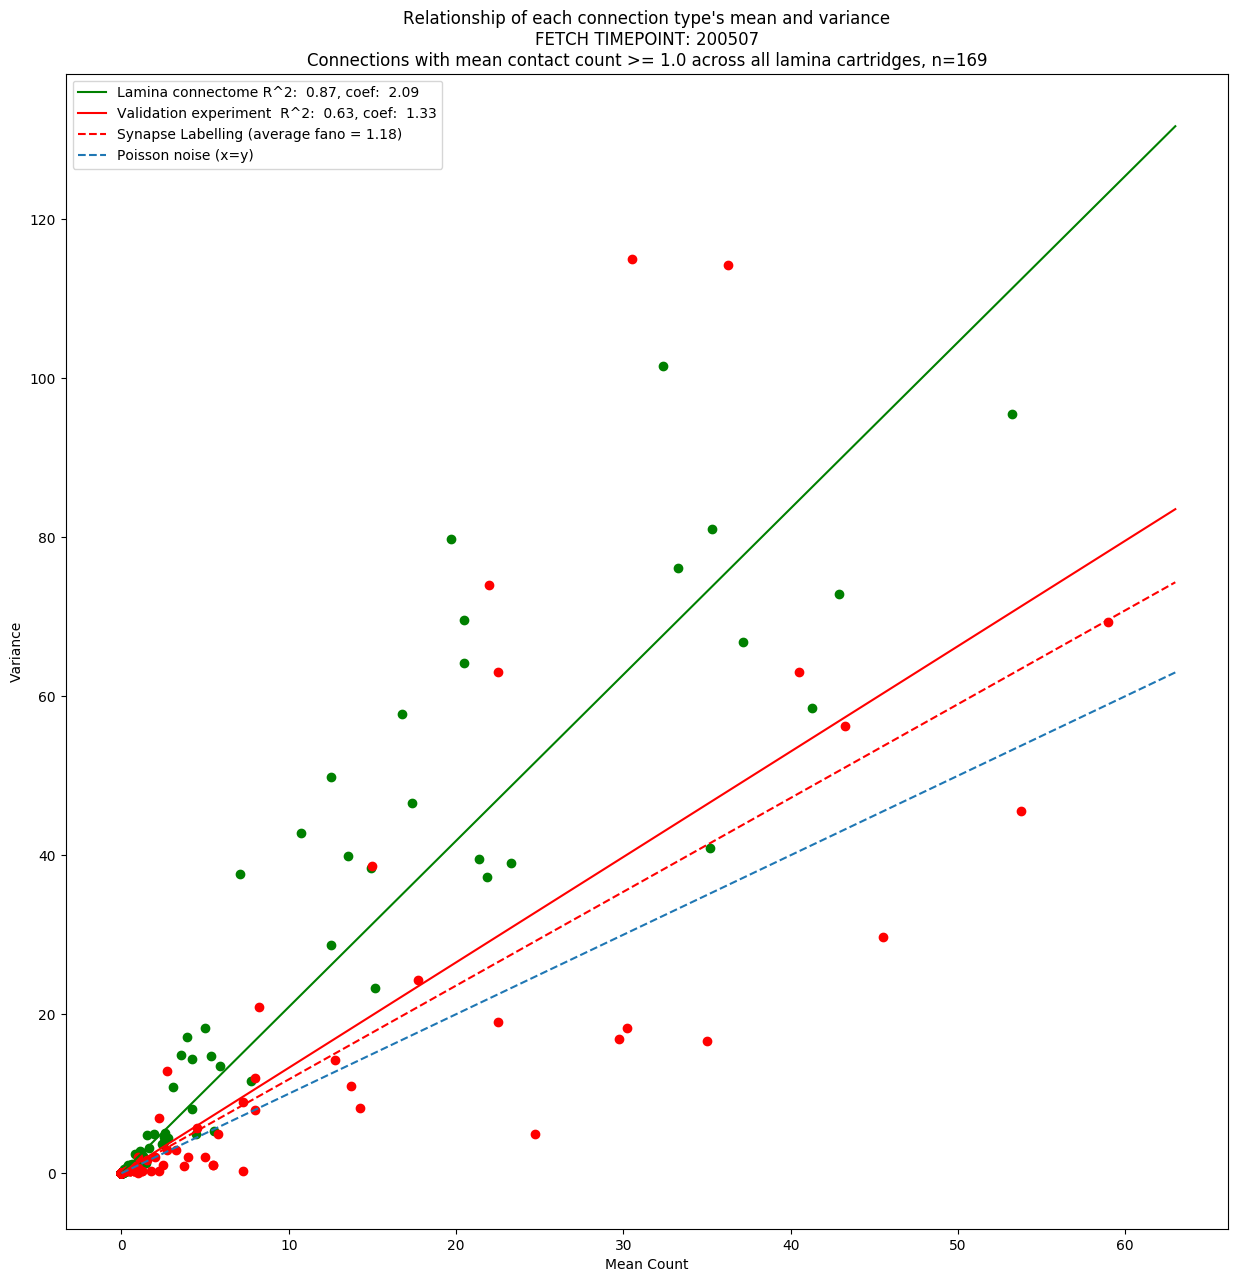

In [47]:
def model_eval(model, x, y):
    return f"R^2: {model.score(x.to_numpy().reshape(-1, 1), y): .2f}, coef: {model.coef_[0]: .2f}"


fig, ax = plt.subplots(1, figsize=[15, 15])
xticks = np.arange(0, max((df_lamina.mean().max(), df_val.mean().max())) + 5).reshape(-1, 1)

#ax.set_xlim(0, max((df_lamina.mean().max(), df_val.mean().max())) + 5)
#ax.set_ylim(0, max((df_lamina.var().max(), df_val.var().max())) + 5)

ax.plot(xticks, lamina_model.predict(xticks), color='g', 
        label=f"Lamina connectome {model_eval(lamina_model, df_lamina.mean(), df_lamina.var())}")
ax.scatter(df_lamina.mean(), df_lamina.std()**2, color='g')
ax.plot(xticks, val_model.predict(xticks), color='r', 
        label=f"Validation experiment  {model_eval(val_model, df_val.mean(), df_val.var())}")
ax.scatter(df_val.mean(), df_val.std()**2, color='r')
ax.plot(xticks, xticks*1.18, '--', color='r', label='Synapse Labelling (average fano = 1.18)')
ax.plot(xticks, xticks, '--', label='Poisson noise (x=y)')

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.legend()
ax.set_title("Relationship of each connection type's mean and variance\n" + 
            f"FETCH TIMEPOINT: {tp}\n"
            f"{incl_method}, n={len(sig_cts)}")
ax.set_xlabel('Mean Count')
ax.set_ylabel('Variance')

fig.savefig('/mnt/home/nchua/Dropbox/200611_validation.pdf')

In [48]:
fano(df_val).T

LMC_1->LMC_1             NaN
LMC_1->LMC_2             NaN
LMC_1->LMC_3             NaN
LMC_1->LMC_4             NaN
LMC_1->LMC_N             NaN
LMC_1->R1R4              NaN
LMC_1->R2R5              NaN
LMC_1->R3R6              NaN
LMC_1->R7                NaN
LMC_1->R7p               NaN
LMC_1->R8                NaN
LMC_1->UNKNOWN           NaN
LMC_1->centri            NaN
LMC_2->LMC_1        1.117647
LMC_2->LMC_2        4.696970
LMC_2->LMC_3        1.366197
LMC_2->LMC_4        0.034483
LMC_2->LMC_N        0.666667
LMC_2->R1R4              NaN
LMC_2->R2R5              NaN
LMC_2->R3R6              NaN
LMC_2->R7           0.333333
LMC_2->R7p          0.855072
LMC_2->R8           0.500000
LMC_2->UNKNOWN           NaN
LMC_2->centri       2.535354
LMC_3->LMC_1             NaN
LMC_3->LMC_2             NaN
LMC_3->LMC_3             NaN
LMC_3->LMC_4             NaN
                      ...   
R8->R7p                  NaN
R8->R8                   NaN
R8->UNKNOWN              NaN
R8->centri    

In [49]:
df_val[ctype_order].var()

R2R5->LMC_2         45.583333
R1R4->LMC_2         69.333333
R3R6->LMC_2         29.666667
R2R5->LMC_3          4.916667
R1R4->LMC_1        114.250000
R2R5->LMC_1         16.666667
R3R6->LMC_1        115.000000
R2R5->centri        56.250000
centri->R7p         18.250000
centri->R2R5        63.000000
LMC_2->LMC_1        14.250000
centri->LMC_2       74.000000
R3R6->LMC_3         16.916667
R1R4->LMC_3         63.000000
LMC_2->LMC_4         0.250000
R2R5->LMC_4          8.000000
centri->R8          19.000000
centri->LMC_3        1.000000
LMC_2->LMC_3        24.250000
R2R5->R7p            8.250000
R1R4->centri        38.666667
R3R6->centri         8.916667
centri->LMC_1       10.916667
centri->R7           1.666667
R3R6->LMC_4          6.916667
R1R4->R2R5           2.916667
R1R4->LMC_4          0.666667
LMC_2->LMC_2        12.916667
R3R6->R2R5           1.000000
LMC_2->R7p           4.916667
                      ...    
centri->UNKNOWN      0.000000
R8->LMC_2            0.000000
R8->LMC_3 

In [50]:
(df_val).T

,bc,mt,nc,sv
LMC_1->LMC_1,0,0,0,0
LMC_1->LMC_2,0,0,0,0
LMC_1->LMC_3,0,0,0,0
LMC_1->LMC_4,0,0,0,0
LMC_1->LMC_N,0,0,0,0
LMC_1->R1R4,0,0,0,0
LMC_1->R2R5,0,0,0,0
LMC_1->R3R6,0,0,0,0
LMC_1->R7,0,0,0,0
LMC_1->R7p,0,0,0,0
